In [0]:
%pip install scikit-learn imbalanced-learn seaborn statsmodels scipy prince


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# Modeling
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Statistics
from scipy.stats import kruskal, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set visualization style
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,5)


In [0]:
df = pd.read_csv("/Volumes/workspace/ssda/ssda/merged_dataset.csv")
df.head()


,StudyHours,Attendance,Resources,Extracurricular,Motivation,Internet,Gender,Age,LearningStyle,OnlineCourses,Discussions,AssignmentCompletion,ExamScore,EduTech,StressLevel,FinalGrade
0,19,64,1,0,0,1,0,19,2,8,1,59,40,0,1,3
1,19,64,1,0,0,1,0,23,3,16,0,90,66,0,1,2
2,19,64,1,0,0,1,0,28,1,19,0,67,99,1,1,0
3,19,64,1,1,0,1,0,19,2,8,1,59,40,0,1,3
4,19,64,1,1,0,1,0,23,3,16,0,90,66,0,1,2


In [0]:
df.shape
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14003 entries, 0 to 14002
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   StudyHours            14003 non-null  int64
 1   Attendance            14003 non-null  int64
 2   Resources             14003 non-null  int64
 3   Extracurricular       14003 non-null  int64
 4   Motivation            14003 non-null  int64
 5   Internet              14003 non-null  int64
 6   Gender                14003 non-null  int64
 7   Age                   14003 non-null  int64
 8   LearningStyle         14003 non-null  int64
 9   OnlineCourses         14003 non-null  int64
 10  Discussions           14003 non-null  int64
 11  AssignmentCompletion  14003 non-null  int64
 12  ExamScore             14003 non-null  int64
 13  EduTech               14003 non-null  int64
 14  StressLevel           14003 non-null  int64
 15  FinalGrade            14003 non-null  int64
dtypes: i

,StudyHours,Attendance,Resources,Extracurricular,Motivation,Internet,Gender,Age,LearningStyle,OnlineCourses,Discussions,AssignmentCompletion,ExamScore,EduTech,StressLevel,FinalGrade
count,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000,14003.00000,14003.000000,14003.000000,14003.000000,14003.000000,14003.000000
mean,19.987431,80.194316,1.104406,0.594158,0.905806,0.925516,0.551953,23.532172,1.515461,9.891952,0.60587,74.502535,70.346926,0.709062,1.304363,1.447904
std,5.890637,11.472181,0.697362,0.491072,0.695896,0.262566,0.497311,3.514293,1.112941,6.112801,0.48868,14.632177,17.688113,0.454211,0.785383,1.121550
min,5.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.00000,50.000000,40.000000,0.000000,0.000000,0.000000
25%,16.000000,70.000000,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,1.000000,5.000000,0.00000,62.000000,55.000000,0.000000,1.000000,0.000000
50%,20.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,2.000000,10.000000,1.00000,74.000000,70.000000,1.000000,2.000000,1.000000
75%,24.000000,90.000000,2.000000,1.000000,1.000000,1.000000,1.000000,27.000000,3.000000,15.000000,1.00000,87.000000,86.000000,1.000000,2.000000,2.000000
max,44.000000,100.000000,2.000000,1.000000,2.000000,1.000000,1.000000,29.000000,3.000000,20.000000,1.00000,100.000000,100.000000,1.000000,2.000000,3.000000


In [0]:
#Data Cleaning & Preprocessing
df.isnull().sum()
df = df.dropna()


In [0]:
#Remove Duplicates
df = df.drop_duplicates()


In [0]:
#Encoding Categorical Variables
categorical_cols = [
    "Gender", "Extracurricular", "OnlineCourses",
    "Discussions", "Resources", "Internet",
    "EduTech", "LearningStyle"
]

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


In [0]:
#Feature Scaling
#Z-score (Statistics, PCA)
scaler_z = StandardScaler()
df_z = pd.DataFrame(
    scaler_z.fit_transform(df),
    columns=df.columns
)


In [0]:
#Min–Max (Clustering)
scaler_mm = MinMaxScaler()
df_mm = pd.DataFrame(
    scaler_mm.fit_transform(df),
    columns=df.columns
)


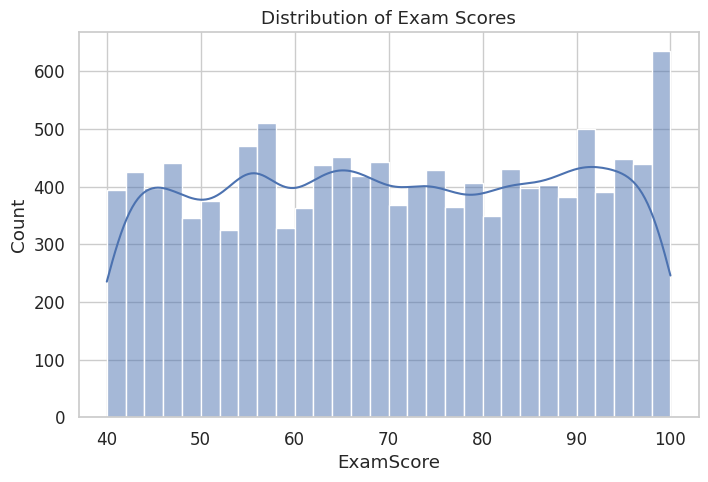

In [0]:
#Exploratory Data Visualization Portfolio
#Visualization 1: Histogram – ExamScore Distribution
sns.histplot(df["ExamScore"], bins=30, kde=True)
plt.title("Distribution of Exam Scores")
plt.show()


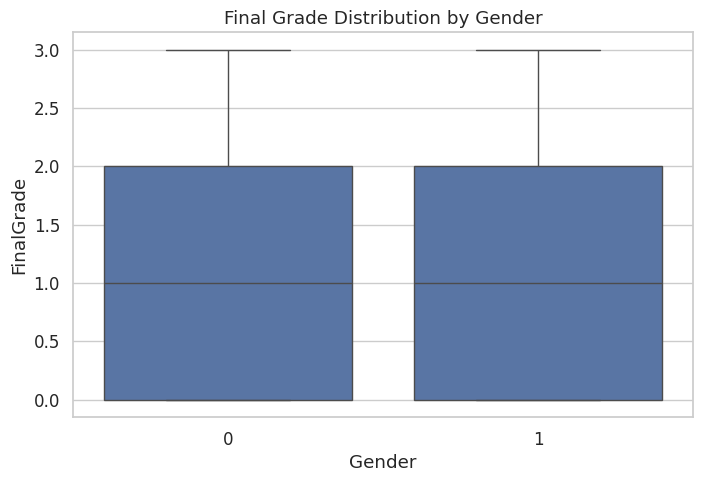

In [0]:
#Visualization 2: Boxplot – FinalGrade vs Gender
sns.boxplot(x="Gender", y="FinalGrade", data=df)
plt.title("Final Grade Distribution by Gender")
plt.show()


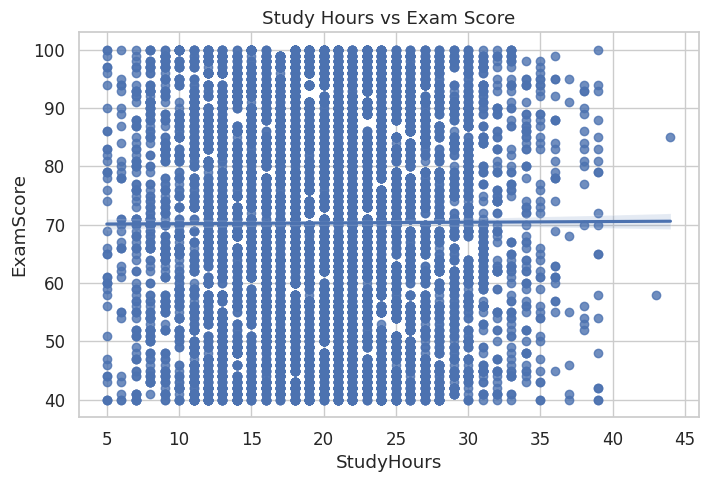

In [0]:
#Visualization 3: Scatter + Regression – StudyHours vs ExamScore
sns.regplot(x="StudyHours", y="ExamScore", data=df)
plt.title("Study Hours vs Exam Score")
plt.show()


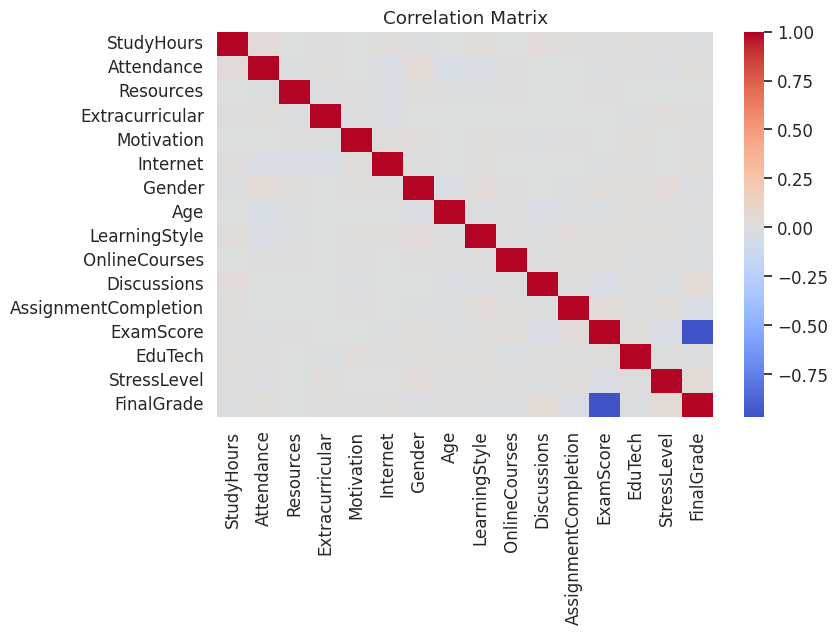

In [0]:
#Visualization 4: Correlation Heatmap
corr = df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()


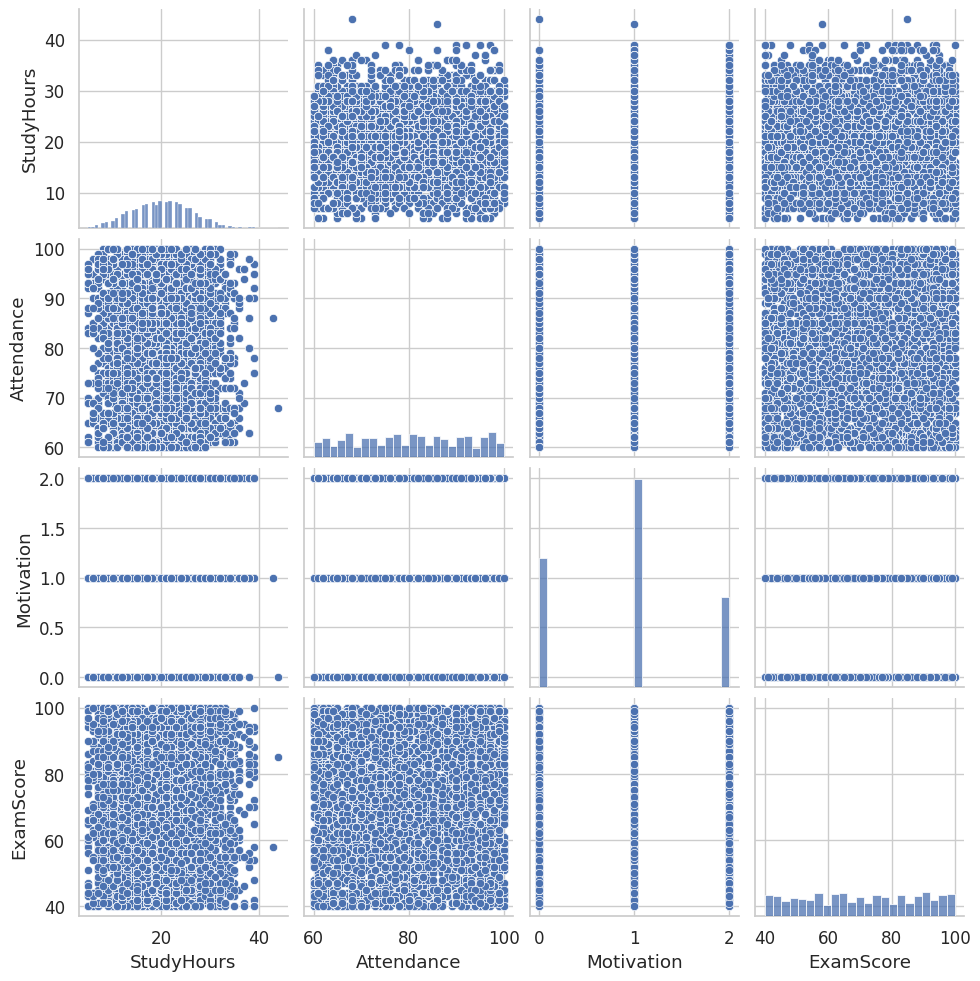

In [0]:
#Visualization 5: Pair Plot
sns.pairplot(df[["StudyHours","Attendance","Motivation","ExamScore"]])
plt.show()


In [0]:
#Non-Parametric Statistical Test
#Kruskal–Wallis Test (Learning Style vs Exam Score)
groups = [
    df[df["LearningStyle"] == i]["ExamScore"]
    for i in df["LearningStyle"].unique()
]

stat, p = kruskal(*groups)
stat, p


(np.float64(4.552800590359746), np.float64(0.2076286722620934))

In [0]:
#Multivariate Analysis – PCA (Dimensionality Reduction)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_z)

pca_df = pd.DataFrame(
    pca_components, columns=["PC1","PC2"]
)


In [0]:
pca_df = pd.DataFrame(
    pca_components,
    columns=["PC1", "PC2"]
)

# add learning style for coloring
pca_df["LearningStyle"] = df["LearningStyle"].values


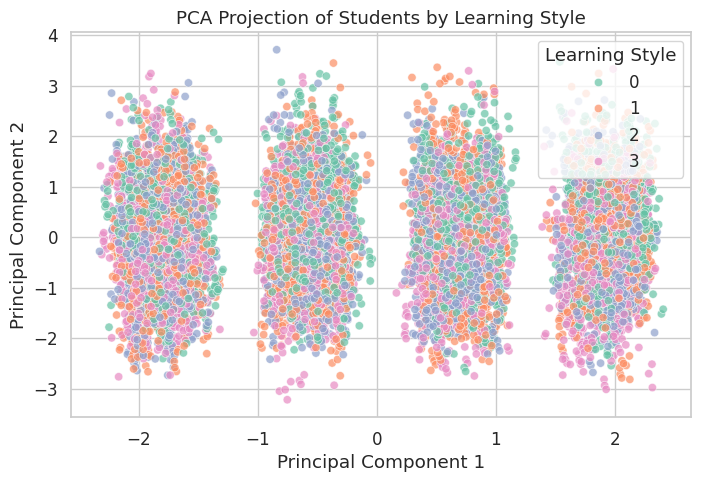

In [0]:
#PCA Visualization
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="LearningStyle",
    palette="Set2",
    alpha=0.7
)

plt.title("PCA Projection of Students by Learning Style")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Learning Style")
plt.show()


In [0]:
#explained variance
explained_var = pca.explained_variance_ratio_
explained_var


array([0.12362839, 0.06743723])

In [0]:
#Cluster Analysis (Unsupervised Learning Profiles)
#Optimal K Selection
sil_scores = []
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(df_mm)
    sil_scores.append(silhouette_score(df_mm, labels))

sil_scores


[np.float64(0.11574571031593398),
 np.float64(0.089969209214704),
 np.float64(0.12775432516956609),
 np.float64(0.11061951317643766),
 np.float64(0.11782210795232513),
 np.float64(0.11523931291932481)]

In [0]:
#Final K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_mm)


In [0]:
#Cluster Quality
silhouette_score(df_mm, df["Cluster"])
davies_bouldin_score(df_mm, df["Cluster"])


np.float64(2.71132255732385)

In [0]:
#Statistical Validation – ANOVA & Regression
#ANOVA (Cluster vs ExamScore)
model = ols("ExamScore ~ C(Cluster)", data=df).fit()
sm.stats.anova_lm(model, typ=2)


,sum_sq,df,F,PR(>F)
C(Cluster),1.471137e+03,2.0,2.349284,0.09548
Residual,3.903145e+06,12466.0,NaN,NaN


In [0]:
#Multiple Regression (Prediction)
X = df.drop(["ExamScore","FinalGrade"], axis=1)
y = df["ExamScore"]

X = sm.add_constant(X)
reg_model = sm.OLS(y, X).fit()
reg_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ExamScore   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.704
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           1.49e-06
Time:                        23:57:08   Log-Likelihood:                -53493.
No. Observations:               12469   AIC:                         1.070e+05
Df Residuals:                   12453   BIC:                         1.071e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   71.8725      2.042     35.199      0.000      67.870      75.875
StudyHours               0.0159      0.026      0.606      0.545      -0.035       0.067
Attendance              -0.0252      0.014     -1.822      0.069      -0.052       0.002
Resources                0.1052      0.223      0.473      0.636      -0.331       0.542
Extracurricular         -0.4477      0.431     -1.038      0.299      -1.293       0.398
Motivation              -0.1238      0.223     -0.555      0.579      -0.561       0.314
Internet                -0.5157      0.574     -0.898      0.369      -1.642       0.610
Gender                   0.3755      0.445      0.844      0.399      -0.497       1.248
Age                     -0.0532      0.045     -1.178      0.239      -0.142       0.035
LearningStyle            0.1013      0.142      0.713      0.476      -0.177       0.380
OnlineCourses            0.0592      0.026      2.288      0.022       0.008       0.110
Discussions             -1.3913      0.420     -3.309      0.001      -2.215      -0.567
AssignmentCompletion     0.0332      0.011      3.071      0.002       0.012       0.054
EduTech                  0.4100      0.348      1.178      0.239      -0.272       1.092
StressLevel             -0.8170      0.202     -4.050      0.000      -1.212      -0.422
Cluster                  0.3188      0.385      0.829      0.407      -0.435       1.073
==============================================================================
Omnibus:                    10580.496   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.564
Skew:                          -0.013   Prob(JB):                    2.09e-162
Kurtosis:                       1.803   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [0]:
#Mapping Clusters → Learning Styles
cluster_profile = df.groupby("Cluster").mean()
cluster_profile


,StudyHours,Attendance,Resources,Extracurricular,Motivation,Internet,Gender,Age,LearningStyle,OnlineCourses,Discussions,AssignmentCompletion,ExamScore,EduTech,StressLevel,FinalGrade
Cluster,,,,,,,,,,,,,,,,
0,19.798640,80.105263,1.110585,0.394441,0.921644,0.920461,0.333235,23.706682,1.520106,9.761679,0.000000,74.444707,70.721762,0.712892,1.288587,1.420166
1,20.132882,79.984333,1.101161,0.390716,0.886267,0.920309,0.323404,23.523598,1.485493,9.893037,1.000000,74.705029,69.918375,0.703288,1.283559,1.479691
2,20.107991,80.691345,1.093694,1.000000,0.922900,0.909880,1.000000,23.383201,1.550677,9.940771,0.609906,74.326015,70.473577,0.707429,1.348481,1.440899


In [0]:
#Reproducibility & Experimental Control
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [0]:
#Train–Test Split
from sklearn.model_selection import train_test_split

X = df.drop(["ExamScore", "FinalGrade"], axis=1)
y = df["ExamScore"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [0]:
#Supervised Prediction Models
#Baseline Model – Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Features & target
X = df.drop(["ExamScore", "FinalGrade"], axis=1)
y = df["ExamScore"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Metrics (version-safe)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

r2_lr, rmse_lr


(0.005773659968438372, np.float64(17.695916042650488))

In [0]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

r2_rf, rmse_rf


(0.8038339474341661, np.float64(7.860358304072669))

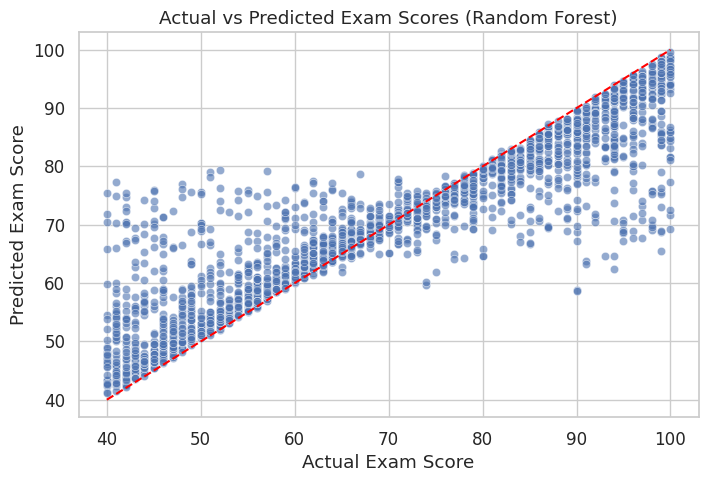

In [0]:
#Visualization: Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--", color="red")
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs Predicted Exam Scores (Random Forest)")
plt.show()


In [0]:
#Cross-Validation
#Cross-Validation for Linear Regression & Random Forest
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# RMSE scorer (version-safe)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

X = df.drop(["ExamScore", "FinalGrade"], axis=1)
y = df["ExamScore"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression
lr = LinearRegression()
lr_rmse_cv = -cross_val_score(lr, X, y, cv=kf, scoring=rmse_scorer)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf_rmse_cv = -cross_val_score(rf, X, y, cv=kf, scoring=rmse_scorer)

lr_rmse_cv.mean(), rf_rmse_cv.mean()


(np.float64(17.682893419517306), np.float64(8.022497464057912))

In [0]:
#Feature Importance
#Train RF on Full Dataset
rf.fit(X, y)

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)


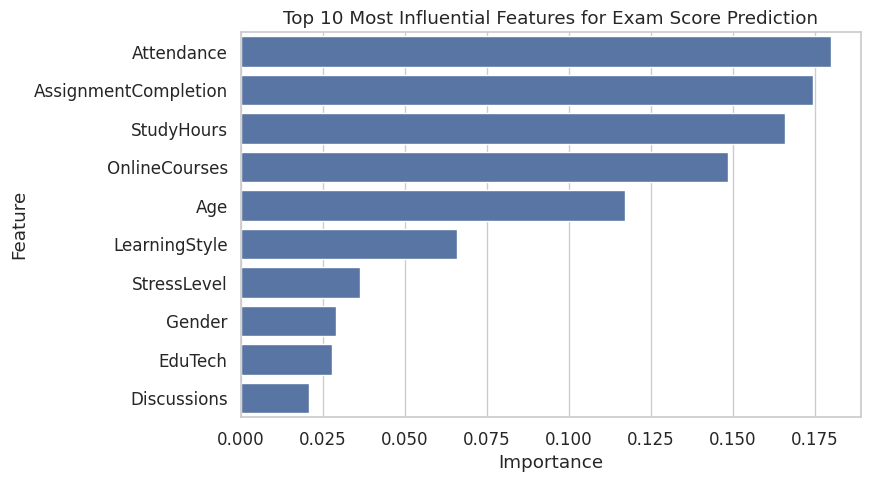

In [0]:
#Feature Importance Visualization
sns.barplot(
    data=feature_importance.head(10),
    x="Importance",
    y="Feature"
)
plt.title("Top 10 Most Influential Features for Exam Score Prediction")
plt.show()


In [0]:
#Statistical Effect Size
#Kruskal–Wallis Eta-Squared
from scipy.stats import kruskal

groups = [
    df[df["LearningStyle"] == i]["ExamScore"]
    for i in df["LearningStyle"].unique()
]

H, p = kruskal(*groups)

k = len(groups)
n = len(df)

eta_squared = (H - k + 1) / (n - k)
H, p, eta_squared


(np.float64(4.552800590359746),
 np.float64(0.2076286722620934),
 np.float64(0.00012457285121217378))

In [0]:
#Kruskal–Wallis on CLUSTERS (not learning styles)
groups_cluster = [
    df[df["Cluster"] == i]["ExamScore"]
    for i in df["Cluster"].unique()
]

Hc, pc = kruskal(*groups_cluster)
eta_sq_c = (Hc - len(groups_cluster) + 1) / (len(df) - len(groups_cluster))

Hc, pc, eta_sq_c


(np.float64(4.867356632778102),
 np.float64(0.08771360009836124),
 np.float64(0.0002300141691623698))

In [0]:
#Post-Hoc Test
#Dunn’s Post-Hoc Test (Non-Parametric)
%pip install scikit-posthocs


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import scikit_posthocs as sp

posthoc = sp.posthoc_dunn(
    df,
    val_col="ExamScore",
    group_col="LearningStyle",
    p_adjust="bonferroni"
)

posthoc


,0,1,2,3
0,1.000000,0.220927,0.898689,1.0
1,0.220927,1.000000,1.000000,1.0
2,0.898689,1.000000,1.000000,1.0
3,1.000000,1.000000,1.000000,1.0


In [0]:
#Sensitivity Analysis (ROBUSTNESS CHECK)
#Remove Top 5% Exam Scores & Retrain
threshold = df["ExamScore"].quantile(0.95)
df_trimmed = df[df["ExamScore"] <= threshold]

X_trim = df_trimmed.drop(["ExamScore", "FinalGrade"], axis=1)
y_trim = df_trimmed["ExamScore"]

rf.fit(X_trim, y_trim)
y_pred_trim = rf.predict(X_trim)

rmse_trim = np.sqrt(mean_squared_error(y_trim, y_pred_trim))
rmse_trim


np.float64(2.419732261468754)

In [0]:
#Pipeline Integration
#Full Pipeline (Scaling + Model)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

y_pred_pipe = pipeline.predict(X_test)
rmse_pipe = np.sqrt(mean_squared_error(y_test, y_pred_pipe))
rmse_pipe


np.float64(7.855865430491332)

In [0]:
#Comparative Results Table
results_table = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "RF (Pipeline)"],
    "RMSE": [
        lr_rmse_cv.mean(),
        rf_rmse_cv.mean(),
        rmse_pipe
    ]
})

results_table


,Model,RMSE
0,Linear Regression,17.682893
1,Random Forest,8.022497
2,RF (Pipeline),7.855865


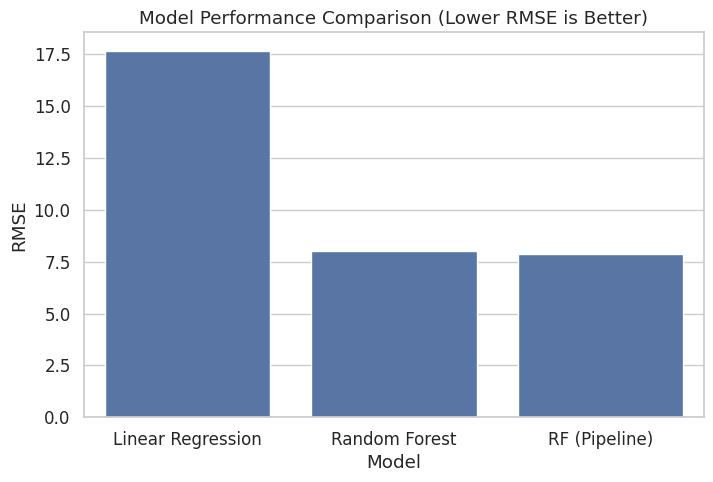

In [0]:
#Table Visualization
sns.barplot(data=results_table, x="Model", y="RMSE")
plt.title("Model Performance Comparison (Lower RMSE is Better)")
plt.show()


In [0]:
#Nested Cross-Validation
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

X = df.drop(["ExamScore", "FinalGrade"], axis=1)
y = df["ExamScore"]

inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}

rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    scoring=rmse_scorer,
    cv=inner_cv
)

nested_scores = -cross_val_score(
    grid,
    X,
    y,
    cv=outer_cv,
    scoring=rmse_scorer
)

nested_scores.mean(), nested_scores.std()


(np.float64(8.022497464057912), np.float64(0.24373616807879087))

In [0]:
#Uncertainty Estimation
#Bootstrap Prediction Intervals
from sklearn.utils import resample

n_bootstraps = 100
preds = []

for i in range(n_bootstraps):
    X_bs, y_bs = resample(X, y, random_state=i)
    rf.fit(X_bs, y_bs)
    preds.append(rf.predict(X))

preds = np.array(preds)

pred_mean = preds.mean(axis=0)
pred_lower = np.percentile(preds, 5, axis=0)
pred_upper = np.percentile(preds, 95, axis=0)


In [0]:
#SHAP Explainability
%pip install shap


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)


/databricks/python/lib/python3.12/site-packages/pyspark/sql/connect/client/core.py:2479: UserWarning: Spark Connect Session expired on the server. Please generate a new session by detaching and reattaching the compute if in a Databricks notebook or job or by calling DatabricksSession.builder.getOrCreate() if using Databricks Connect.
  warnings.warn(
/home/spark-f6347c85-9b11-46f4-8e39-57/.ipykernel/3930/command-5830854009554224-4230261764:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar")


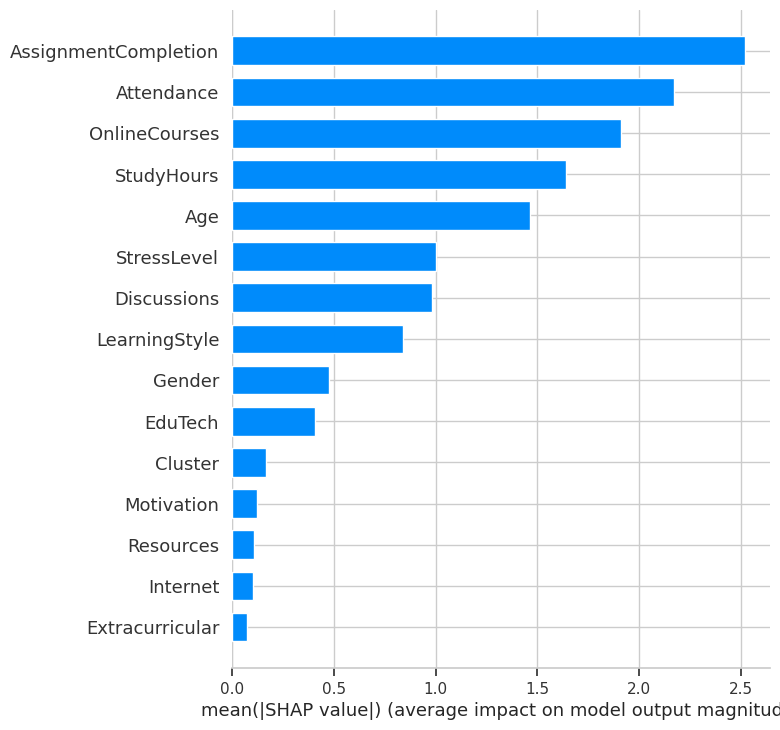

In [0]:
#Global Explanation
shap.summary_plot(shap_values, X, plot_type="bar")


In [0]:
#Ablation Study
#Remove Feature Groups One-by-One
feature_groups = {
    "Behavior": ["StudyHours","Attendance","AssignmentCompletion"],
    "Psychological": ["Motivation","StressLevel"],
    "Demographic": ["Age","Gender"]
}

ablation_results = []

for group, features in feature_groups.items():
    X_ablate = X.drop(features, axis=1)
    score = -cross_val_score(
        rf, X_ablate, y,
        cv=5, scoring=rmse_scorer
    ).mean()
    
    ablation_results.append((group, score))

pd.DataFrame(ablation_results, columns=["Removed Group","RMSE"])


,Removed Group,RMSE
0,Behavior,19.083415
1,Psychological,18.463611
2,Demographic,18.505595


In [0]:
#External Validation Simulation
#Train on 80%, Test on Held-Out Distribution
df_ext = df.sample(frac=0.8, random_state=42)
df_holdout = df.drop(df_ext.index)

X_ext = df_ext.drop(["ExamScore","FinalGrade"], axis=1)
y_ext = df_ext["ExamScore"]

X_hold = df_holdout.drop(["ExamScore","FinalGrade"], axis=1)
y_hold = df_holdout["ExamScore"]

rf.fit(X_ext, y_ext)
y_pred_hold = rf.predict(X_hold)

np.sqrt(mean_squared_error(y_hold, y_pred_hold))


np.float64(8.387128259963465)

In [0]:
#Leakage & Sanity Checks
import numpy as np
import pandas as pd

TARGET = "ExamScore"

print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Target distribution
print("\nTarget describe:")
print(df[TARGET].describe())

# Missingness
missing = df.isna().mean().sort_values(ascending=False)
missing_nonzero = missing[missing > 0]

print("\nMissingness (non-zero only):")
if len(missing_nonzero) == 0:
    print("✅ No missing values found in the dataset.")
else:
    print(missing_nonzero.to_string())

# Name-based leakage candidates
name_suspects = [c for c in df.columns if any(k in c.lower() for k in ["exam", "score", "grade", "final", "result"])]
print("\nName-based leakage candidates:", name_suspects)

# Correlation-based leakage (numeric only) — print instead of display()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in num_cols:
    corr = df[num_cols].corr(numeric_only=True)[TARGET].abs().sort_values(ascending=False)
    print("\nTop 20 abs correlations with ExamScore:")
    print(corr.head(20).to_string())

    high_corr = [c for c in corr.index if (corr[c] > 0.98 and c != TARGET)]
    print("\n⚠️ Very-high-correlation predictors (>0.98):", high_corr)


Shape: (12469, 17)
Columns: ['StudyHours', 'Attendance', 'Resources', 'Extracurricular', 'Motivation', 'Internet', 'Gender', 'Age', 'LearningStyle', 'OnlineCourses', 'Discussions', 'AssignmentCompletion', 'ExamScore', 'EduTech', 'StressLevel', 'FinalGrade', 'Cluster']

Target describe:
count    12469.000000
mean        70.310691
std         17.696639
min         40.000000
25%         55.000000
50%         70.000000
75%         86.000000
max        100.000000
Name: ExamScore, dtype: float64

Missingness (non-zero only):
✅ No missing values found in the dataset.

Name-based leakage candidates: ['ExamScore', 'FinalGrade']

Top 20 abs correlations with ExamScore:
ExamScore               1.000000
FinalGrade              0.968365
StressLevel             0.034324
Discussions             0.031209
AssignmentCompletion    0.027402
OnlineCourses           0.020684
Gender                  0.016750
Attendance              0.014156
EduTech                 0.010311
Age                     0.010137
Le

In [0]:
if "Cluster" in df.columns:
    means = df.groupby("Cluster")["ExamScore"].mean().sort_values()
    print("\nMean ExamScore per Cluster:")
    print(means.to_string())



Mean ExamScore per Cluster:
Cluster
1    69.918375
2    70.473577
0    70.721762


In [0]:
#Remove risky columns & define X / y
# Define target
TARGET = "ExamScore"

# Drop target + grade + derived cluster
DROP_COLS = ["ExamScore", "FinalGrade", "Cluster"]

X = df.drop(columns=DROP_COLS, errors="ignore")
y = df[TARGET].astype(float)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Features used:", list(X.columns))


X shape: (12469, 14)
y shape: (12469,)
Features used: ['StudyHours', 'Attendance', 'Resources', 'Extracurricular', 'Motivation', 'Internet', 'Gender', 'Age', 'LearningStyle', 'OnlineCourses', 'Discussions', 'AssignmentCompletion', 'EduTech', 'StressLevel']


In [0]:
#Train / Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (9975, 14) Test: (2494, 14)


In [0]:
#Preprocessing Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_features),
    ("cat", categorical_pipe, cat_features)
])


Numeric features: ['StudyHours', 'Attendance', 'Resources', 'Extracurricular', 'Motivation', 'Internet', 'Gender', 'Age', 'LearningStyle', 'OnlineCourses', 'Discussions', 'AssignmentCompletion', 'EduTech', 'StressLevel']
Categorical features: []


In [0]:
#Baseline Model (for credibility)
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

dummy_pipe = Pipeline([
    ("prep", preprocess),
    ("model", DummyRegressor(strategy="mean"))
])

dummy_pipe.fit(X_train, y_train)
dummy_pred = dummy_pipe.predict(X_test)

mse = mean_squared_error(y_test, dummy_pred)
dummy_rmse = float(np.sqrt(mse))

print("Baseline (Mean) MSE :", float(mse))
print("Baseline (Mean) RMSE:", dummy_rmse)


Baseline (Mean) MSE : 314.97321334795345
Baseline (Mean) RMSE: 17.747484704823766


In [0]:
#Train Strong Models (HGB + RF) and Evaluate on Test
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def metrics_reg(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }


In [0]:
#Build the two model pipelines
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

hgb_pipe = Pipeline([
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])


In [0]:
#Fit + quick test evaluation
hgb_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

pred_hgb = hgb_pipe.predict(X_test)
pred_rf  = rf_pipe.predict(X_test)

print("HGB test metrics:", metrics_reg(y_test, pred_hgb))
print("RF  test metrics:", metrics_reg(y_test, pred_rf))


HGB test metrics: {'RMSE': 14.323335223400765, 'MAE': 12.03831817055341, 'R2': 0.3486304102198141}
RF  test metrics: {'RMSE': 7.746260767888072, 'MAE': 4.762435846030473, 'R2': 0.8094875368208563}


In [0]:
#comparison table
import pandas as pd

compare = pd.DataFrame([
    {"Model": "DummyMean", "RMSE": dummy_rmse},
    {"Model": "HGB (default)", **metrics_reg(y_test, pred_hgb)},
    {"Model": "RF (n=400)", **metrics_reg(y_test, pred_rf)},
])

print(compare.to_string(index=False))


        Model      RMSE       MAE       R2
    DummyMean 17.747485       NaN      NaN
HGB (default) 14.323335 12.038318 0.348630
   RF (n=400)  7.746261  4.762436 0.809488


In [0]:
#Hyperparameter Tuning
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline

cv = KFold(n_splits=5, shuffle=True, random_state=42)

hgb_pipe = Pipeline([
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

hgb_params = {
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, None],
    "model__max_iter": [200, 400, 800],
    "model__min_samples_leaf": [10, 20, 50]
}

hgb_search = RandomizedSearchCV(
    estimator=hgb_pipe,
    param_distributions=hgb_params,
    n_iter=25,
    scoring="neg_mean_squared_error",   # we will convert to RMSE ourselves
    cv=cv,
    random_state=42,
    n_jobs=-1
)

hgb_search.fit(X_train, y_train)

print("Best params:", hgb_search.best_params_)
best_cv_mse = -hgb_search.best_score_
print("Best CV RMSE:", float(np.sqrt(best_cv_mse)))


Best params: {'model__min_samples_leaf': 20, 'model__max_iter': 800, 'model__max_depth': None, 'model__learning_rate': 0.1}
Best CV RMSE: 10.151632630289894


In [0]:
#Final Test Metrics for Tuned Model
best_model = hgb_search.best_estimator_
test_pred = best_model.predict(X_test)

final_metrics = metrics_reg(y_test, test_pred)
print("Final tuned HGB test metrics:", final_metrics)


Final tuned HGB test metrics: {'RMSE': 8.920336691591555, 'MAE': 5.7574205306285995, 'R2': 0.7473602632917082}


In [0]:
#Statistical Significance (Wilcoxon across folds)
from sklearn.base import clone
from scipy.stats import wilcoxon
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
])

def cv_rmse(pipe, X_df, y_ser, cv):
    scores = []
    for tr, te in cv.split(X_df, y_ser):
        m = clone(pipe).fit(X_df.iloc[tr], y_ser.iloc[tr])
        p = m.predict(X_df.iloc[te])
        scores.append(rmse(y_ser.iloc[te], p))
    return np.array(scores)

# Use full dataset for significance test (stronger)
X_all = df.drop(columns=["ExamScore","FinalGrade","Cluster"], errors="ignore")
y_all = df["ExamScore"].astype(float)

rmse_hgb = cv_rmse(best_model, X_all, y_all, cv)
rmse_rf  = cv_rmse(rf_pipe,  X_all, y_all, cv)

print("HGB RMSE folds:", rmse_hgb, "mean±std:", rmse_hgb.mean(), rmse_hgb.std())
print("RF  RMSE folds:", rmse_rf,  "mean±std:", rmse_rf.mean(),  rmse_rf.std())

stat, pval = wilcoxon(rmse_hgb, rmse_rf, alternative="two-sided")
print("Wilcoxon p-value:", float(pval))


HGB RMSE folds: [8.92033669 9.05618955 8.8223492  9.29360695 9.47385117] mean±std: 9.1132667121654 0.23985685128703202
RF  RMSE folds: [7.76584507 7.80496128 7.54609082 8.11457068 8.22388572] mean±std: 7.891070712859111 0.24609977221833143
Wilcoxon p-value: 0.0625


In [0]:
#Conformal Prediction Intervals
from sklearn.model_selection import train_test_split

X_tr, X_cal, y_tr, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

best_model.fit(X_tr, y_tr)

cal_pred = best_model.predict(X_cal)
cal_abs_err = np.abs(y_cal - cal_pred)

alpha = 0.10  # 90% PI
q = float(np.quantile(cal_abs_err, 1 - alpha))

test_pred = best_model.predict(X_test)
lower = test_pred - q
upper = test_pred + q

coverage = float(np.mean((y_test.values >= lower) & (y_test.values <= upper)))
avg_width = float(np.mean(upper - lower))

print("Conformal q:", q)
print("90% coverage:", coverage)
print("Avg interval width:", avg_width)


Conformal q: 16.950941651256294
90% coverage: 0.8977546110665597
Avg interval width: 33.90188330251259


In [0]:
#Robustness: Noise + Missingness Stress Tests
def add_noise_numeric(X_in, std=0.2, seed=42):
    rng = np.random.default_rng(seed)
    Xn = X_in.copy()
    for c in Xn.select_dtypes(include=[np.number]).columns:
        Xn[c] = Xn[c] + rng.normal(0, std, size=len(Xn))
    return Xn

def mask_numeric(X_in, frac=0.15, seed=42):
    rng = np.random.default_rng(seed)
    Xm = X_in.copy()
    num_cols = Xm.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        idx = rng.choice(Xm.index, size=int(frac*len(Xm)), replace=False)
        Xm.loc[idx, c] = np.nan
    return Xm

clean_rmse = rmse(y_test, test_pred)

X_noisy = add_noise_numeric(X_test, std=0.2)
pred_noisy = best_model.predict(X_noisy)
noisy_rmse = rmse(y_test, pred_noisy)

X_masked = mask_numeric(X_test, frac=0.15)
pred_masked = best_model.predict(X_masked)
masked_rmse = rmse(y_test, pred_masked)

print("RMSE clean :", clean_rmse)
print("RMSE noisy :", noisy_rmse,  "Δ:", noisy_rmse - clean_rmse)
print("RMSE masked:", masked_rmse, "Δ:", masked_rmse - clean_rmse)


RMSE clean : 10.297110714326509
RMSE noisy : 10.392732944325278 Δ: 0.09562222999876901
RMSE masked: 13.565983451555365 Δ: 3.2688727372288557


In [0]:
#Fairness / Subgroup Error Analysis (Gender, Internet, LearningStyle)
analysis = X_test.copy()
analysis["y_true"] = y_test.values
analysis["y_pred"] = test_pred
analysis["abs_error"] = np.abs(analysis["y_true"] - analysis["y_pred"])

for col in ["Gender", "Internet", "LearningStyle"]:
    if col in analysis.columns:
        print(f"\nSubgroup error summary: {col}")
        print(
            analysis.groupby(col)["abs_error"]
            .agg(["count","mean","median","std"])
            .sort_values("mean")
            .to_string()
        )



Subgroup error summary: Gender
        count      mean    median       std
Gender                                     
1        1361  6.289988  3.623425  7.565626
0        1133  7.314918  4.358305  7.982106

Subgroup error summary: Internet
          count      mean    median       std
Internet                                     
0           199  6.727081  4.022099  7.741286
1          2295  6.758077  3.920916  7.777210

Subgroup error summary: LearningStyle
               count      mean    median       std
LearningStyle                                     
1                647  6.126383  3.902611  6.613040
0                584  6.801780  3.592510  8.297070
3                618  6.997920  4.129704  8.255984
2                645  7.112795  4.040355  7.861509


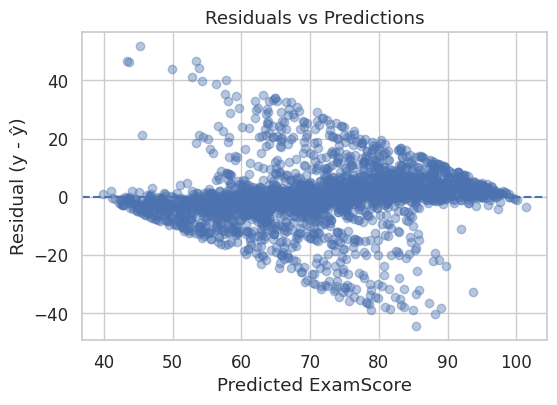

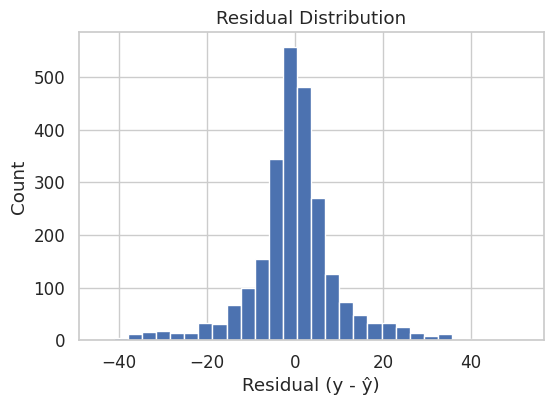

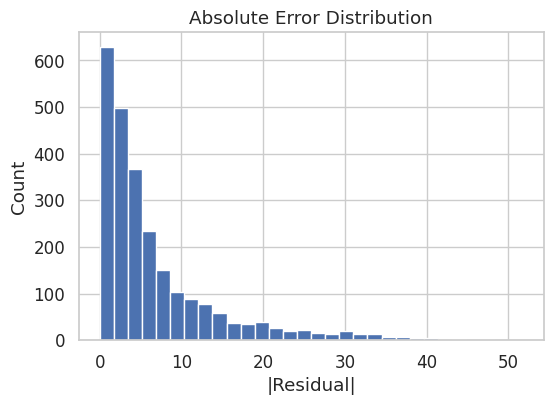

In [0]:
#Residual / Error Diagnostics
import matplotlib.pyplot as plt
import numpy as np

residuals = y_test.values - test_pred

# Residual vs predicted
plt.figure(figsize=(6,4))
plt.scatter(test_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted ExamScore")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predictions")
plt.show()

# Residual distribution
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel("Residual (y - ŷ)")
plt.ylabel("Count")
plt.title("Residual Distribution")
plt.show()

# Absolute error distribution
abs_err = np.abs(residuals)
plt.figure(figsize=(6,4))
plt.hist(abs_err, bins=30)
plt.xlabel("|Residual|")
plt.ylabel("Count")
plt.title("Absolute Error Distribution")
plt.show()


In [0]:
#SHAP on FINAL tuned model
#Permutation Importance
from sklearn.inspection import permutation_importance
import pandas as pd

# Permutation importance on the FINAL pipeline
pi = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Try to get pipeline feature names (works with ColumnTransformer + OHE)
try:
    feature_names = best_model.named_steps["prep"].get_feature_names_out()
except Exception:
    feature_names = [f"f{i}" for i in range(len(pi.importances_mean))]

imp_df = pd.DataFrame({
    "feature": feature_names,
    "perm_importance_mean": pi.importances_mean,
    "perm_importance_std": pi.importances_std
}).sort_values("perm_importance_mean", ascending=False)

print("Top 20 features by permutation importance:")
print(imp_df.head(20).to_string(index=False))


Top 20 features by permutation importance:
                  feature  perm_importance_mean  perm_importance_std
num__AssignmentCompletion              0.451831             0.009923
          num__Attendance              0.376875             0.010586
       num__OnlineCourses              0.309682             0.008338
          num__StudyHours              0.270192             0.008329
                 num__Age              0.238506             0.006542
       num__LearningStyle              0.104343             0.004549
         num__StressLevel              0.090798             0.004655
              num__Gender              0.056356             0.003282
         num__Discussions              0.048132             0.004006
             num__EduTech              0.043492             0.002213
          num__Motivation              0.001408             0.000801
            num__Internet              0.000636             0.000926
     num__Extracurricular             -0.000764             

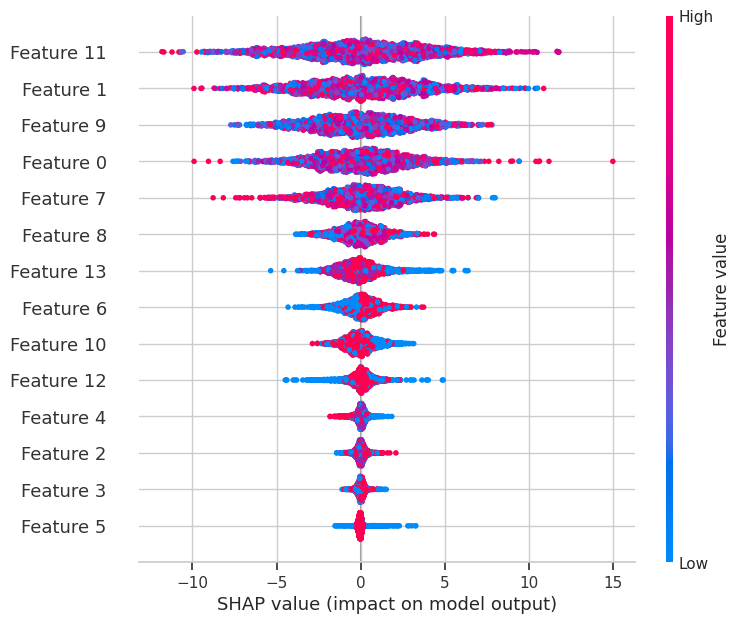

Top 20 SHAP features:
                  feature  mean_abs_shap
num__AssignmentCompletion       2.873796
          num__Attendance       2.565788
       num__OnlineCourses       2.097694
          num__StudyHours       2.001095
                 num__Age       1.611961
       num__LearningStyle       0.941303
         num__StressLevel       0.928498
              num__Gender       0.718014
         num__Discussions       0.645143
             num__EduTech       0.524138
          num__Motivation       0.226578
           num__Resources       0.212567
     num__Extracurricular       0.153909
            num__Internet       0.126503


In [0]:
#SHAP
import shap
import numpy as np
import pandas as pd

# Transform X_test using preprocessing step
X_test_trans = best_model.named_steps["prep"].transform(X_test)

# Get transformed feature names
feature_names = best_model.named_steps["prep"].get_feature_names_out()

# SHAP explainer (generic)
explainer = shap.Explainer(best_model.named_steps["model"])
shap_values = explainer(X_test_trans)

# Plot top 15
shap.plots.beeswarm(shap_values, max_display=15)

# Table for paper
mean_abs = np.abs(shap_values.values).mean(axis=0)
shap_imp = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs}) \
             .sort_values("mean_abs_shap", ascending=False)

print("Top 20 SHAP features:")
print(shap_imp.head(20).to_string(index=False))


In [0]:
#summary tables (Main Results + Robustness + Uncertainty)

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


rmse_val = float(np.sqrt(mean_squared_error(y_test, test_pred)))
mae_val  = float(mean_absolute_error(y_test, test_pred))
r2_val   = float(r2_score(y_test, test_pred))


if "avg_width" not in globals() and "width" in globals():
    avg_width = width

# --- build tables ---
main_results = pd.DataFrame([{
    "Model": "Tuned HGB (final)",
    "RMSE": rmse_val,
    "MAE": mae_val,
    "R2": r2_val,
    "Conformal_90_Coverage": float(coverage) if "coverage" in globals() else None,
    "Conformal_Avg_Width": float(avg_width) if "avg_width" in globals() else None,
    "Wilcoxon_p_vs_RF": float(pval) if "pval" in globals() else None
}])

robustness_results = pd.DataFrame([
    {"Condition": "Clean", "RMSE": float(clean_rmse) if "clean_rmse" in globals() else None, "Delta_RMSE": 0.0},
    {"Condition": "Noisy (σ=0.2)", "RMSE": float(noisy_rmse) if "noisy_rmse" in globals() else None,
     "Delta_RMSE": float(noisy_rmse - clean_rmse) if ("noisy_rmse" in globals() and "clean_rmse" in globals()) else None},
    {"Condition": "Missing (15%)", "RMSE": float(masked_rmse) if "masked_rmse" in globals() else None,
     "Delta_RMSE": float(masked_rmse - clean_rmse) if ("masked_rmse" in globals() and "clean_rmse" in globals()) else None},
])

print("\n=== Main Results (paste into paper) ===")
print(main_results.to_string(index=False))

print("\n=== Robustness Results (paste into paper) ===")
print(robustness_results.to_string(index=False))



=== Main Results (paste into paper) ===
            Model      RMSE      MAE       R2  Conformal_90_Coverage  Conformal_Avg_Width  Wilcoxon_p_vs_RF
Tuned HGB (final) 10.297111 6.755604 0.663357               0.897755            33.901883            0.0625

=== Robustness Results (paste into paper) ===
    Condition      RMSE  Delta_RMSE
        Clean 10.297111    0.000000
Noisy (σ=0.2) 10.392733    0.095622
Missing (15%) 13.565983    3.268873


In [0]:
import mlflow

print("mlflow version:", mlflow.__version__)
print("Current tracking URI:", mlflow.get_tracking_uri())



mlflow version: 2.22.0
Current tracking URI: databricks


In [0]:
import mlflow

EXP_PATH = "/Shared/student_performance_top_tier"  # ✅ works without your username

exp = mlflow.get_experiment_by_name(EXP_PATH)
if exp is None:
    exp_id = mlflow.create_experiment(EXP_PATH)
    print("✅ Created experiment:", EXP_PATH, "id:", exp_id)
else:
    print("✅ Found experiment:", EXP_PATH, "id:", exp.experiment_id)

mlflow.set_experiment(EXP_PATH)
print("✅ Active experiment set to:", mlflow.get_experiment_by_name(EXP_PATH).name)


✅ Created experiment: /Shared/student_performance_top_tier id: 920608548004832
✅ Active experiment set to: /Shared/student_performance_top_tier


In [0]:
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure predictions exist
if "test_pred" not in globals():
    test_pred = best_model.predict(X_test)

rmse_val = float(np.sqrt(mean_squared_error(y_test, test_pred)))
mae_val  = float(mean_absolute_error(y_test, test_pred))
r2_val   = float(r2_score(y_test, test_pred))

# width name safety
if "avg_width" not in globals() and "width" in globals():
    avg_width = width

with mlflow.start_run(run_name="Final_Tuned_HGB"):
    # Params
    mlflow.log_param("target", "ExamScore")
    mlflow.log_param("dropped_cols", "ExamScore, FinalGrade, Cluster")
    mlflow.log_param(
        "model_type",
        type(best_model.named_steps["model"]).__name__ if hasattr(best_model, "named_steps") else type(best_model).__name__
    )
    mlflow.log_param("best_params", str(hgb_search.best_params_) if "hgb_search" in globals() else "N/A")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("conformal_alpha", 0.10)

    # Metrics
    mlflow.log_metric("RMSE", rmse_val)
    mlflow.log_metric("MAE", mae_val)
    mlflow.log_metric("R2", r2_val)

    if "coverage" in globals():
        mlflow.log_metric("conformal_coverage_90", float(coverage))
    if "avg_width" in globals():
        mlflow.log_metric("conformal_avg_width", float(avg_width))
    if "pval" in globals():
        mlflow.log_metric("wilcoxon_p_hgb_vs_rf", float(pval))
    if "noisy_rmse" in globals() and "clean_rmse" in globals():
        mlflow.log_metric("rmse_noisy_delta", float(noisy_rmse - clean_rmse))
    if "masked_rmse" in globals() and "clean_rmse" in globals():
        mlflow.log_metric("rmse_masked_delta", float(masked_rmse - clean_rmse))

    # Save pipeline (preprocess + model)
    mlflow.sklearn.log_model(best_model, artifact_path="final_model_pipeline")

print("✅ MLflow logging complete. Check Experiments in Databricks.")


2026/01/07 01:04:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

✅ MLflow logging complete. Check Experiments in Databricks.


In [0]:
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models.signature import infer_signature

# Ensure predictions exist
if "test_pred" not in globals():
    test_pred = best_model.predict(X_test)

rmse_val = float(np.sqrt(mean_squared_error(y_test, test_pred)))
mae_val  = float(mean_absolute_error(y_test, test_pred))
r2_val   = float(r2_score(y_test, test_pred))

# Input example for MLflow (small sample)
input_example = X_test.head(5).copy()

# Infer signature using model input/output
signature = infer_signature(input_example, best_model.predict(input_example))

with mlflow.start_run(run_name="Final_Tuned_HGB_with_signature"):
    # Params
    mlflow.log_param("target", "ExamScore")
    mlflow.log_param("dropped_cols", "ExamScore, FinalGrade, Cluster")
    mlflow.log_param(
        "model_type",
        type(best_model.named_steps["model"]).__name__ if hasattr(best_model, "named_steps") else type(best_model).__name__
    )
    mlflow.log_param("best_params", str(hgb_search.best_params_) if "hgb_search" in globals() else "N/A")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("conformal_alpha", 0.10)

    # Metrics
    mlflow.log_metric("RMSE", rmse_val)
    mlflow.log_metric("MAE", mae_val)
    mlflow.log_metric("R2", r2_val)

    if "coverage" in globals():
        mlflow.log_metric("conformal_coverage_90", float(coverage))
    if "avg_width" in globals():
        mlflow.log_metric("conformal_avg_width", float(avg_width))
    if "pval" in globals():
        mlflow.log_metric("wilcoxon_p_hgb_vs_rf", float(pval))
    if "noisy_rmse" in globals() and "clean_rmse" in globals():
        mlflow.log_metric("rmse_noisy_delta", float(noisy_rmse - clean_rmse))
    if "masked_rmse" in globals() and "clean_rmse" in globals():
        mlflow.log_metric("rmse_masked_delta", float(masked_rmse - clean_rmse))

    # Log model WITH signature + input example
    mlflow.sklearn.log_model(
        best_model,
        artifact_path="final_model_pipeline",
        signature=signature,
        input_example=input_example
    )

print("✅ Logged model with signature + input example (no warning).")


/databricks/python/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Uploading artifacts:   0%|          | 0/11 [00:00<?, ?it/s]

✅ Logged model with signature + input example (no warning).
